In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Viton data parser

In [3]:
import os
import cv2
import random
import json
from collections import defaultdict

root = "viton_resize/train/"

class GarmentParser:
    def __init__(self, root):
        self.root = root
        self.image_dir = os.path.join(root, 'image')
        self.image_parse_dir = os.path.join(root, 'image-parse')
        self.cloth_dir = os.path.join(root, 'cloth')
        self.cloth_mask_dir = os.path.join(root, 'cloth-mask')
        self.pose_dir = os.path.join(root, 'pose')
        self.id_map = defaultdict(dict)
        self.build()

    def build(self):
        for img_fp in os.listdir(self.image_dir):
            id = img_fp.split('_')[0]
            self.id_map[id]['image'] = os.path.join(self.image_dir, img_fp)
        for img_mask_fp in os.listdir(self.image_parse_dir):
            id = img_mask_fp.split('_')[0]
            self.id_map[id]['image_mask'] = os.path.join(self.image_parse_dir, 
                                                         img_mask_fp)
        for cloth_fp in os.listdir(self.cloth_dir):
            id = cloth_fp.split('_')[0]
            self.id_map[id]['cloth'] = os.path.join(self.cloth_dir, cloth_fp)
        for cloth_mask_fp in os.listdir(self.cloth_mask_dir):
            id = cloth_mask_fp.split('_')[0]
            self.id_map[id]['cloth_mask'] = os.path.join(self.cloth_mask_dir, 
                                                    cloth_mask_fp)
        for pose_fp in os.listdir(self.pose_dir):
            id = pose_fp.split('_')[0]
            with open(os.path.join(self.pose_dir, pose_fp)) as f:
                info = json.load(f)
            self.id_map[id]['people'] = info['people']
        self.ids = list(self.id_map.keys())

    def load(self, idx):
        id = self.ids[idx]
        return id, self.id_map[id]

    def load_random(self):
        idx = random.randint(0, len(self.ids)-1)
        return self.load(idx)

    def __len__(self):
        return len(self.id_map)

In [4]:
import sys
sys.path.append("./DL-models-experiments/")

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from torchvision import transforms as T

## Dataset for training

In [6]:
def get_normalizer(dim=3, mu=0.5, std=0.5):
    return T.Compose(
        [T.ToTensor(),
        T.Normalize([mu] * dim, [std] * dim)
        ]
    )

class DescriptorDataset(Dataset):
    def __init__(self, gparser, split='train', 
                 image_size=(256, 192), 
                 kp_thresh=0.1, kp_rad=10):
        super(DescriptorDataset, self).__init__()
        self.gparser = gparser
        self.split = split
        self.image_size = image_size
        self.kp_thresh = kp_thresh
        self.kp_rad = kp_rad
        self.hid_size = (16, 32)
        self.normalizer = {1: get_normalizer(1), 
                           3: get_normalizer(3), 
                           25: get_normalizer(25)}

    def __getitem__(self, idx):
        if self.split == 'train':
            id, sample = self.gparser.load_random()
        else:
            id, sample = self.gparser.load(idx)
        image = cv2.imread(sample['image'])[..., ::-1] / 255
        image_mask = cv2.imread(sample['image_mask'])[..., ::-1] / 255.
        hand_mask = np.where(image_mask[..., 1] > 0.5, 1, 0)
        image_mask = image_mask.sum(2)
        face_mask = np.where(np.abs(image_mask-1.) < 0.1, 1, 0)
        hand_mask = hand_mask * self.binary_mask(sample, ids=[4, 7], rad=30).sum(2)
        lower_body_mask = np.where(np.abs(image_mask-0.66) < 0.1, 1, 0)
        body_mask = np.where(np.abs(image_mask-1) > 0.1, 1, 0)
        face_pic = image * (hand_mask[..., None] + \
                            face_mask[..., None] + \
                            lower_body_mask[..., None]).astype(np.float32)
        body_mask = (image_mask * body_mask).astype(bool).astype(np.float32)
        up_cloth_mask = np.where(np.abs(image_mask-1.3294117) < 0.1, 1, 0)
        body_mask_down = cv2.resize(body_mask, self.hid_size)
        body_mask_down = cv2.resize(body_mask_down, self.image_size[::-1])
        body_mask_down = body_mask_down[..., None]
        kps_mask = self.binary_mask(sample)
        cloth = cv2.imread(sample['cloth'])[..., ::-1] / 255.
        cloth_mask = cv2.imread(sample['cloth_mask']).mean(2) / 255.
        desc = np.concatenate([kps_mask, body_mask_down, 
                               face_pic, cloth], axis=2)
        target = image

        return self.preprocess(desc), \
            self.preprocess(target), \
            self.preprocess(up_cloth_mask), \
            self.preprocess(cloth_mask)

    def binary_mask(self, sample, ids=None, rad=None):
        if rad is None:
            rad = self.kp_rad
        assert len(sample['people']) == 1
        kps = np.array(sample['people'][0]['pose_keypoints']).reshape(-1, 3)
        if ids is not None:
            kps = kps[ids]
        N, _ = kps.shape
        H, W = self.image_size
        mask = np.zeros((*self.image_size, N))
        for i in range(N):
            kp_x, kp_y, kp_proba = kps[i]
            kp_x, kp_y = int(kp_x), int(kp_y)
            if kp_proba < self.kp_thresh:
                continue
            lim_low_x, lim_low_y = max(0, kp_x - rad), max(0, kp_y - rad)
            lim_high_x, lim_high_y = min(W-1, kp_x+rad), min(H-1, kp_y+rad)
            for xx in range(lim_low_x, lim_high_x):
                for yy in range(lim_low_y, lim_high_y):
                    if (xx-kp_x)**2 + (yy-kp_y)**2 < rad**2:
                        mask[yy, xx, i] = 1.
        return mask

    def preprocess(self, inp):
        if len(inp.shape) == 2:
            inp = inp[..., None]
        dim = inp.shape[-1]
        inp = self.normalizer[dim](inp.astype(np.float32))
        return inp.float()
            
    def __len__(self):
        return len(self.gparser)

## Refenement and TPS Regression models

In [7]:
from torchvision.models import resnet18
import torch.nn as nn
import tqdm
from models.tps_grid_gen import TpsGridGen
from models.unet import Unet
from models.senet import SEUnetResnet50
import torch.nn.functional as F

In [8]:
def sn_conv2d(in_ch, out_ch, ksize=1, padding=0, bias=True):
    return nn.utils.spectral_norm(nn.Conv2d(in_ch, out_ch, ksize,
                                            stride=1, padding=padding,
                                            bias=bias))

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, ksize=1, padding=0, bias=True):
        super(ConvBlock, self).__init__() 
        self.conv = sn_conv2d(in_ch, out_ch, ksize, padding, bias)
        self.bn = nn.BatchNorm2d(out_ch)
        self.relu = nn.LeakyReLU(0.1)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class RefinementModel(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(RefinementModel, self).__init__() 
        self.block1 = ConvBlock(in_dim, 64)
        self.block2 = ConvBlock(64, 64)
        self.block3 = ConvBlock(64, 64)
        self.block4 = ConvBlock(64, 64)
        self.conv5 = sn_conv2d(64, 1, 1, bias=False)
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.conv5(x)
        return x

In [9]:
class RegressionModel(nn.Module):
    def __init__(self, grid_size):
        super(RegressionModel, self).__init__()
        N = 2 * grid_size**2
        self.base = resnet18(num_classes=N)
        self.base.conv1 = nn.Conv2d(2, 64, kernel_size=(7, 7), 
                                    stride=(2, 2), padding=(3, 3), bias=False)
        
    def forward(self, x, y):
        inp = torch.cat([x, y], 1)
        return self.base(inp)
    
from collections import defaultdict
import tqdm

class Logger:
    def __init__(self):
        self.loss = defaultdict(list)
    
    def update(self, **loss):
        for (k, v) in loss.items():
            self.loss[k].append(v)

## VVG19 for perceptual loss

In [10]:
from torchvision.models import vgg
vgg_model = vgg.vgg19(pretrained=True).eval()

from collections import namedtuple
LossOutput = namedtuple("LossOutput", ["relu1_2", 
                                       "relu2_2", 
                                       "relu3_2", 
                                       "relu4_2", 
                                       'relu5_2'])

class LossNetwork(torch.nn.Module):
    def __init__(self, vgg_model):
        super(LossNetwork, self).__init__()
        self.vgg_layers = vgg_model.features
        self.layer_name_mapping = {
            '3': "relu1_2",
            '8': "relu2_2",
            '13': 'relu3_2',
            '22': 'relu4_2',
            '31': 'relu5_2',
        }
    
    def forward(self, x, refinement=False):
        output = {}
        for name, module in self.vgg_layers._modules.items():
            with torch.no_grad():
                x = module(x)
            if name in self.layer_name_mapping:
                if refinement and int(name) < 13:
                    # don't use lower layers output during refinement
                    output[self.layer_name_mapping[name]] = torch.zeros(1).cuda()
                else:
                    output[self.layer_name_mapping[name]] = x
        return LossOutput(**output)

In [11]:
def perceptual_loss(gt, out, loss_model, crit, refinement=False):
    mean = torch.tensor([0.485, 0.456, 0.406])[None, :, None, None].cuda()
    std = torch.tensor([0.229, 0.224, 0.225])[None, :, None, None].cuda()
    gt = (gt + 1.) / 2.
    gt = (gt - mean) / std
    out = (out + 1.) / 2.
    out = (out - mean) / std
    feats1 = loss_model(gt, refinement=refinement)
    feats2 = loss_model(out, refinement=refinement)
    loss = 0.
    for (x, y) in zip(feats1, feats2):
        loss += crit(x, y)
    return loss

## Training

In [12]:
SCALE = 0.1

def train_step(coarse_model, regr_model, refine_net, grid_gen,
               desc, gt, raw_mask, deform_mask, raw_cloth,
               loss_model, crit,
               opt_coarse, opt_regr, opt_refine,
               train_regr=True, mode='train'):
    if mode == 'train':
        opt_coarse.zero_grad()
        opt_regr.zero_grad()
        opt_refine.zero_grad()
    
    # Generate mask and coarse result from descriptor
    coarse_result = coarse_model(desc)
    coarse_mask, coarse_cloth = coarse_result[:, :1], coarse_result[:, 1:] 

    coarse_loss = crit(deform_mask, coarse_mask) + crit(gt, coarse_cloth)
    coarse_loss += perceptual_loss(gt, coarse_cloth, loss_model, crit)

    # Generate Theta for TPS
    theta = regr_model(raw_mask, coarse_mask) * SCALE
    
    deform_mask = deform_mask.repeat(1, 3, 1, 1)
    deform_cloth = torch.where(deform_mask > 0, gt, -torch.ones(1).cuda())
    raw_mask = raw_mask.repeat(1, 3, 1, 1)
    raw_cloth = torch.where(raw_mask > 0, raw_cloth, -torch.ones(1).cuda())
    
    # Apply TPS to mask and raw cloth
    grid = grid_gen(theta)
    warped_mask = F.grid_sample(raw_mask[:, :1], grid, padding_mode='border')
    warped_cloth = F.grid_sample(raw_cloth, grid, padding_mode='border')
    
    tps_loss = crit(warped_mask, deform_mask[:, :1]) + crit(warped_cloth, deform_cloth)
    tps_loss += perceptual_loss(deform_cloth, warped_cloth, loss_model, crit)
    
    coarse_inp = torch.cat([warped_cloth, 
                            coarse_cloth], dim=1)
    # Generate refinement mask
    refined_mask = refine_net(coarse_inp).sigmoid()


    refined = refined_mask * warped_cloth + (1 - refined_mask) * coarse_cloth
    refine_loss = perceptual_loss(gt, refined, loss_model, crit, refinement=True)
    refine_loss += crit(gt, refined)
    refine_loss -= 0.1 * refined_mask.mean()

    if mode == 'train':
        coarse_loss.backward(retain_graph=True)
        tps_loss.backward(retain_graph=True)
        refine_loss.backward()
        opt_coarse.step()
        opt_regr.step()
        
        torch.nn.utils.clip_grad_norm_(refine_net.parameters(), max_norm=10.)
        opt_refine.step()
    return coarse_loss, tps_loss, refine_loss


def train_single_epoch(coarse_model, regr_model, refine_net, grid_gen,
                       loss_model, crit, opt_coarse, opt_regr, opt_refine,
                       train_regr,
                       dataloader, logger, epoch, postfix_dict={}, device="cuda"):
    coarse_model.train()
    regr_model.train()
    refine_net.train()
    
    total_step = len(dataloader)
    total_loss = 0.
    tbar = tqdm.tqdm(enumerate(dataloader), total=total_step, position=0)

    for i, (desc, gt, deform_mask, raw_mask) in tbar:
        desc = desc.to(device)
        deform_mask = deform_mask.to(device)
        raw_mask = raw_mask.to(device)
        gt = gt.to(device)
        raw_cloth = desc[:, 22:]

        coarse_loss, tps_loss, refine_loss = train_step(coarse_model, regr_model, refine_net, grid_gen, 
                                           desc, gt, raw_mask, deform_mask, raw_cloth, 
                                           loss_model, crit, 
                                           opt_coarse, opt_regr, opt_refine, 
                                           train_regr)
        total_loss += coarse_loss.item() + tps_loss.item() + refine_loss.item()
        postfix_dict["train/closs"] = coarse_loss.item()
        postfix_dict["train/tloss"] = tps_loss.item()
        postfix_dict["train/rloss"] = refine_loss.item()
        f_epoch = epoch + i / total_step
        desc = '{:5s}'.format('train')
        desc += ', {:04d}/{:04d}, {:.2f} epoch'.format(i, total_step, f_epoch)
        tbar.set_description(desc)
        tbar.set_postfix(**postfix_dict)
    total_loss /= total_step
    logger.update(**{'train/loss': total_loss})

def eval_single_epoch(coarse_model, regr_model, refine_net, grid_gen,
                      loss_model, crit, opt_coarse, opt_regr, opt_refine, train_regr,
                      dataloader, logger, epoch, postfix_dict={}, device="cuda"):
    coarse_model.eval()
    regr_model.eval()
    refine_net.eval()
    total_step = len(dataloader)
    total_loss = 0.
    tbar = tqdm.tqdm(enumerate(dataloader), total=total_step, position=0)

    for i, (desc, gt, deform_mask, raw_mask) in tbar:
        desc = desc.to(device)
        deform_mask = deform_mask.to(device)
        raw_mask = raw_mask.to(device)
        gt = gt.to(device)
        raw_cloth = desc[:, 22:]

        coarse_loss, tps_loss, refine_loss = train_step(coarse_model, regr_model, refine_net, grid_gen, 
                                           desc, gt, raw_mask, deform_mask, raw_cloth, 
                                           loss_model, crit, 
                                           opt_coarse, opt_regr, opt_refine, 
                                           train_regr)
        total_loss += coarse_loss.item() + tps_loss.item() + refine_loss.item()
        postfix_dict["val/closs"] = coarse_loss.item()
        postfix_dict["val/tloss"] = tps_loss.item()
        postfix_dict["val/rloss"] = refine_loss.item()
        f_epoch = epoch + i / total_step
        desc = '{:5s}'.format('val')
        desc += ', {:04d}/{:04d}, {:.2f} epoch'.format(i, total_step, f_epoch)
        tbar.set_description(desc)
        tbar.set_postfix(**postfix_dict)
    total_loss /= total_step
    logger.update(**{'val/loss': total_loss})

def train(coarse_model, regr_model, refine_net, grid_gen, opt_coarse, opt_regr, opt_refine,
          train_loader, val_loader, 
          loss_model, crit, logger, epochs=20):
    postfix_dict = {}
    for epoch in range(epochs):
        # train_regr = False if epoch < 1 else True
        train_regr = True
        train_single_epoch(coarse_model, regr_model, refine_net, grid_gen,
                       loss_model, crit, opt_coarse, opt_regr, opt_refine, train_regr,
                       train_loader, logger, epoch, 
                       postfix_dict=postfix_dict)
        eval_single_epoch(coarse_model, regr_model, refine_net, grid_gen,
                      loss_model, crit, opt_coarse, opt_regr, opt_refine, train_regr,
                      val_loader, logger, epoch, 
                      postfix_dict=postfix_dict)

In [13]:
grid_size = 5
regr_model = RegressionModel(grid_size=grid_size).cuda()
grid_gen = TpsGridGen(grid_size=grid_size, use_cuda=True, reg_factor=0.)
loss_model = LossNetwork(vgg_model).cuda()
coarse_model = Unet(25, 4, activation='tanh').cuda()
crit = torch.nn.SmoothL1Loss().cuda()
refine_net = RefinementModel(6, 1).cuda()

In [14]:
ckpt = torch.load('./coarse_model.pth')['state_dict']
coarse_model.load_state_dict(ckpt)

ckpt = torch.load('./regr_model.pth')['state_dict']
regr_model.load_state_dict(ckpt)

# ckpt = torch.load('./refine_net.pth')['state_dict']
# refine_net.load_state_dict(ckpt)

<All keys matched successfully>

In [15]:
opt_coarse = torch.optim.Adam(coarse_model.parameters(), lr=5e-5)
opt_regr = torch.optim.Adam(regr_model.parameters(), lr=5e-5)
opt_refine = torch.optim.Adam(refine_net.parameters(), lr=1e-4, weight_decay=1e-2)

gparser = GarmentParser("./viton_resize/train")
train_data = DescriptorDataset(gparser, split='train')
train_loader = DataLoader(train_data, shuffle=True, batch_size=24, num_workers=8)

gparser = GarmentParser("./viton_resize/test")
val_data = DescriptorDataset(gparser, split='val')
val_loader = DataLoader(val_data, shuffle=True, batch_size=24, num_workers=8)

logger = Logger()

In [ ]:
train(coarse_model, regr_model, refine_net, grid_gen,
      opt_coarse, opt_regr, opt_refine,
      train_loader, val_loader, 
      loss_model, crit, logger, epochs=10)

  0%|          | 0/593 [00:00<?, ?it/s]/home/user/conda/lib/python3.7/site-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/user/conda/lib/python3.7/site-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
train, 0241/0593, 8.41 epoch:  41%|████      | 242/593 [04:41<06:47,  1.16s/it, train/closs=2.27, train/rloss=1.83, train/tloss=2.11, val/closs=2.13, val/rloss=1.74, val/tloss=1.56]

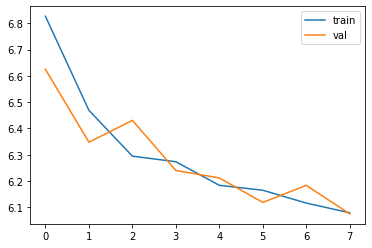

In [17]:
plt.plot(logger.loss['train/loss'], label='train')
plt.plot(logger.loss['val/loss'], label='val')
plt.legend()

## Model's intermidiate outputs

In [18]:
def inference(coarse_model, regr_model, refine_net, grid_gen,
             desc, gt, raw_mask, deform_mask):
    regr_model.eval()
    coarse_model.eval()
    refine_net.eval()

    raw_cloth = desc[:, 22:]

    coarse_result = coarse_model(desc)
    coarse_mask, coarse_cloth = coarse_result[:, :1], coarse_result[:, 1:] 
    theta = regr_model(raw_mask, coarse_mask) * SCALE

    deform_mask = deform_mask.repeat(1, 3, 1, 1)
    deform_cloth = torch.where(deform_mask > 0, gt, -torch.ones(1).cuda())
    raw_mask = raw_mask.repeat(1, 3, 1, 1)
    raw_cloth = torch.where(raw_mask > 0, raw_cloth, -torch.ones(1).cuda())

    grid = grid_gen(theta)
    warped_mask = F.grid_sample(raw_mask[:, :1], grid, padding_mode='border')
    warped_cloth = F.grid_sample(raw_cloth, grid, padding_mode='border')

    coarse_inp = torch.cat([warped_cloth, 
                            coarse_cloth], dim=1)
    
    refined_mask = refine_net(coarse_inp).sigmoid()
    refined = refined_mask * warped_cloth + (1 - refined_mask) * coarse_cloth
    
    return gt, raw_cloth, coarse_mask, coarse_cloth, warped_cloth, refined, refined_mask

In [56]:
gparser = GarmentParser("./viton_resize/test")
val_data = DescriptorDataset(gparser, split='val')

desc, gt, deform_mask, raw_mask = val_data[random.randint(0, len(val_data)-1)]
# desc, gt, deform_mask, raw_mask = val_data[3]
gt = gt[None].cuda()
desc = desc[None].cuda()
deform_mask = deform_mask[None].cuda()
raw_mask = raw_mask[None].cuda()

gt, raw_cloth, coarse_mask, coarse_cloth, warped_cloth, refined, refined_mask = inference(coarse_model, 
                                                                                          regr_model, 
                                                                                          refine_net, 
                                                                                          grid_gen, 
                                                                                          desc, 
                                                                                          gt, raw_mask, 
                                                                                          deform_mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


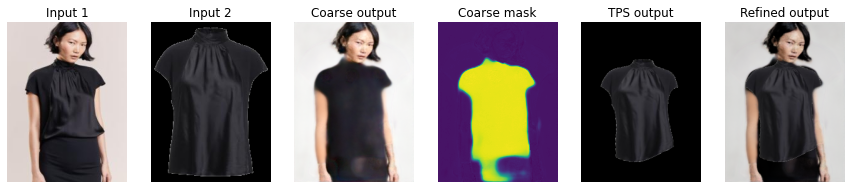

In [57]:
plt.figure(figsize=(15, 12))
plt.subplot(161)
img = 0.5 + 0.5 * gt
plt.imshow(img[0].detach().cpu().numpy().transpose(1, 2, 0))
plt.axis('off')
plt.title('Input 1')
plt.subplot(162)
img = 0.5 + 0.5 * raw_cloth
plt.imshow(img[0].detach().cpu().numpy().transpose(1, 2, 0))
plt.axis('off')
plt.title('Input 2')
plt.subplot(163)
img = 0.5 + 0.5 * coarse_cloth
plt.imshow(img[0].detach().cpu().numpy().transpose(1, 2, 0))
plt.axis('off')
plt.title('Coarse output')
plt.subplot(164)
img = 0.5 + 0.5 * coarse_mask
plt.imshow(img[0, 0].detach().cpu().numpy())
plt.axis('off')
plt.title('Coarse mask')
plt.subplot(165)
img = 0.5 + 0.5 * warped_cloth
plt.imshow(img[0].detach().cpu().numpy().transpose(1, 2, 0))
plt.axis('off')
plt.title('TPS output')
plt.subplot(166)
img = 0.5 + 0.5 * refined
img = torch.clamp(img, 0, 1)
# plt.imshow(img[0, 0].detach().cpu().numpy())
plt.imshow(img[0].detach().cpu().numpy().transpose(1, 2, 0))
plt.axis('off')
plt.title('Refined output');

## Cloth swapping

In [79]:
def inference(coarse_model, regr_model, refine_net, grid_gen,
             desc, raw_mask):
    regr_model.eval()
    coarse_model.eval()
    refine_net.eval()

    raw_cloth = desc[:, 22:]
    coarse_result = coarse_model(desc)
    coarse_mask, coarse_cloth = coarse_result[:, :1], coarse_result[:, 1:] 
    theta = regr_model(raw_mask, coarse_mask) * SCALE

    raw_mask = raw_mask.repeat(1, 3, 1, 1)
    raw_cloth = torch.where(raw_mask > 0, raw_cloth, -torch.ones(1).cuda())

    grid = grid_gen(theta)
    warped_cloth = F.grid_sample(raw_cloth, grid, padding_mode='border')

    coarse_inp = torch.cat([warped_cloth, 
                            coarse_cloth], dim=1)
    
    refined_mask = refine_net(coarse_inp).sigmoid()
    refined = refined_mask * warped_cloth + (1 - refined_mask) * coarse_cloth
    
    return refined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


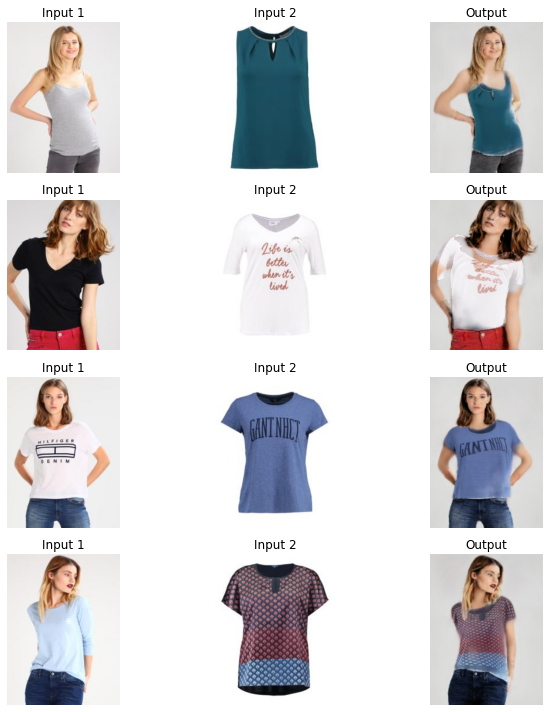

In [98]:
plt.figure(figsize=(10, 10))

for i in range(4):
    desc_person, gt_person, _, _ = val_data[random.randint(0, len(val_data)-1)]
    desc_cloth, _, _, raw_mask = val_data[random.randint(0, len(val_data)-1)]
    mix_desc = torch.cat([desc_person[:22], desc_cloth[22:]], 0)
    res = inference(coarse_model, regr_model, refine_net, grid_gen, 
                    mix_desc[None].cuda(), raw_mask[None].cuda())

    plt.subplot(4, 3, 2*i + i+1)
    img = 0.5 + 0.5 * gt_person.detach().cpu().numpy().transpose(1, 2, 0)
    plt.imshow(img)
    plt.title('Input 1')
    plt.axis('off')
    plt.subplot(4, 3, 2*i + i+2)
    img = 0.5 + 0.5 * desc_cloth[22:].detach().cpu().numpy().transpose(1, 2, 0)
    plt.imshow(img)
    plt.title('Input 2')
    plt.axis('off')
    plt.subplot(4, 3, 2*i + i+3)
    img = 0.5 + 0.5 * res[0].detach().cpu().numpy().transpose(1, 2, 0)
    plt.imshow(img)
    plt.title('Output')
    plt.axis('off')
    
plt.tight_layout()